# Apply RVAE for FashionMNIST data set
* <b>Objective:</b> In this problem, the purpose is trian a robust varational autoencoder when the training is polluted with outliers. Here we chose shoes and sneakers as inliers classes and samples from other categories as outliers. Since these images contain a significant range of gray scales, we chose the Gaussian model. 

In [45]:
from __future__ import print_function
import argparse
import torch
import math
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
import scipy.io as spio
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define parameters
seed:random seed 
epochs:number of epochs
CODE_SIZE: z dimention
SIGMA:constant variance for Guassian loss function
batch_size:batch size for training
log_interval:how many batches to wait before logging training status

In [8]:
seed = 10004
epochs = 150 
batch_size = 120
log_interval = 10
CODE_SIZE = 20
SIGMA = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creat data for test loader and train loader
input: anomoly percentage
output: train_loader, test_loader

In [35]:
def create_data(frac_anom):

    torch.manual_seed(seed=seed)
    np.random.seed(seed=seed)

    (X, X_lab), (_test_images, _test_lab) = fashion_mnist.load_data()
    X_lab = np.array(X_lab)

    # find other categories
    ind = np.isin(X_lab, (0, 1, 2, 3, 4, 5, 6, 8))  #(1, 5, 7, 9)
    X_lab_outliers = X_lab[ind]
    X_outliers = X[ind]

    # find sneaker and ankle boots
    ind = np.isin(X_lab, (7, 9))  # (0, 2, 3, 4, 6))  #
    X_lab = X_lab[ind]
    X = X[ind]

    #normalize the data
    X = X / 255.0
    X_outliers = X_outliers / 255.0

    # add ouliers to the data the label for outliers is 10
    Nsamp = np.int(np.rint(len(X) * frac_anom)) + 1
    X[:Nsamp, :, :] = X_outliers[:Nsamp, :, :]
    X_lab[:Nsamp] = 10

    #split data to train and test
    X_train, X_test, X_lab_train, X_lab_test = train_test_split(
        X, X_lab, test_size=0.33, random_state=10003)
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


    
    #append samples and labels
    train_data = []
    for i in range(len(X_train)):
        train_data.append(
            [torch.from_numpy(X_train[i]).float(), X_lab_train[i]])

    test_data = []
    for i in range(len(X_test)):
        test_data.append(
            [torch.from_numpy(X_test[i]).float(), X_lab_test[i]])
        
        
    #generate train loader and test loader
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=len(test_data),
                                              shuffle=False)

    return train_loader, test_loader

# Define MSE loss and beta loss for Guassian posterior


In [36]:
#MSE loss
def MSE_loss(Y, X):
    ret = (X - Y)**2
    ret = torch.sum(ret)
    return ret

#beta loss
def SE_loss(Y,X):
    ret = (X - Y)**2
    ret = torch.sum(ret,1)
    return ret
    
def Gaussian_CE_loss(Y, X, beta, sigma=SIGMA):  # 784 for mnist
    Dim = Y.shape[1]
    const1 = -((1 + beta) / beta)
    const2 = 1 / pow((2 * math.pi * (sigma**2)), (beta * Dim / 2))
    SE = SE_loss(Y, X)
    term1 = torch.exp(-(beta / (2 * (sigma**2))) * SE)
    loss = torch.sum(const1 * (const2* term1 - 1))
    return loss


def beta_loss_function(recon_x, x, mu, logvar, beta):

    if beta > 0:
        # If beta is nonzero, use the beta entropy
        BBCE = Gaussian_CE_loss(recon_x.view(-1, 784), x.view(-1, 784), beta)
    else:
        # if beta is zero use binary cross entropy
        BBCE = MSE_loss(recon_x.view(-1, 784), x.view(-1, 784))

    # compute KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BBCE + KLD

# Define network

In [37]:
class RVAE(nn.Module):
    def __init__(self):
        super(RVAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, CODE_SIZE)
        self.fc22 = nn.Linear(400, CODE_SIZE)
        self.fc3 = nn.Linear(CODE_SIZE, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    
    # for reseting network weights
    def weight_reset(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

# Define model reset
This function calls weight_reset from the network class and reset the weights of the network.

In [38]:
def model_reset():
    model.weight_reset()

# Define model and optimizer

In [39]:
model = RVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training function
input: number of epochs, value of beta

Prints loss after each log intervalof bathces and after each epoch

In [40]:
def train(epoch, beta_val):
    model.train()
    train_loss = 0
    for batch_idx, (data, data_lab) in enumerate(train_loader):
   
        data = (data).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = beta_loss_function(recon_batch, data, mu, logvar, beta=beta_val)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

# Testing function
input: number of epochs, value of beta
out put: total loss for the test samples, loss for the inlier samples in the test, loss for the out lier samples in the test
Saves the resconstruction of 8 random samples(4 inliers, 4 outliers)
Saves data, reconstruction and anomolies lables in a npz file

In [41]:
def test(frac_anom, beta_val):
    model.eval()
    test_loss_total = 0
    test_loss_anom = 0
    num_anom = 0
    with torch.no_grad():
        for i, (data, data_lab) in enumerate(test_loader):
        
            data = (data).to(device)
            recon_batch, mu, logvar = model(data)
            anom_lab = data_lab == 10
            num_anom += np.sum(anom_lab.numpy())  # count number of anomalies
            anom_lab = (anom_lab[:, None].float()).to(device)

            test_loss_anom += MSE_loss(recon_batch * anom_lab,
                                      data * anom_lab).item()
            test_loss_total += MSE_loss(recon_batch, data).item()

            if i == 0:
                n = min(data.size(0), 100)
                samp=[4, 14, 50, 60, 25, 29, 32, 65]
                comparison = torch.cat([
                    data.view(len(recon_batch), 1, 28, 28)[samp],
                    recon_batch.view(len(recon_batch), 1, 28, 28)[samp]
                ])
                save_image(comparison.cpu(),
                           'results/fashion_mnist_recon_shallow_' +
                           str(beta_val) + '_' + str(frac_anom) + '.png',
                           nrow=n)

        np.savez('results/fashion_mnist_' + str(beta_val) + '_' +
                 str(frac_anom) + '.npz',
                 recon=recon_batch.cpu(),
                 data=data.cpu(),
                 anom_lab=anom_lab.cpu())

    test_loss_normals = (test_loss_total - test_loss_anom) / (
        len(test_loader.dataset) - num_anom)
    test_loss_anom /= num_anom
    test_loss_total /= len(test_loader.dataset)

    print('====> Test set loss: {:.4f}'.format(test_loss_total))

    return test_loss_total, test_loss_anom, test_loss_normals


# Main function

Runs training and testing for a givern values of beta and percentage of anomolies

In [42]:
if __name__ == "__main__":

    brange=[0,0.01]
    erange = range(1, epochs + 1)
    anrange = np.array([0.01,0.05,0.1])
    
    test_loss_total = np.zeros((len(anrange), len(brange)))
    test_loss_anom = np.zeros((len(anrange), len(brange)))
    test_loss_normals = np.zeros((len(anrange), len(brange)))

    for b, betaval in enumerate(brange):

        for a, frac_anom in enumerate(anrange):
            train_loader, test_loader = create_data(frac_anom)
            model_reset()
            for epoch in erange:

                train(epoch, beta_val=betaval)

                print('epoch: %d, beta=%g, frac_anom=%g' %
                      (epoch, betaval, frac_anom))

            # save the model
            torch.save(model, '/results/fashion_mnist_beta_shallow_' + str(betaval) + '_frac_anom_' + str(frac_anom))

            test_loss_total[a, b], test_loss_anom[a, b], test_loss_normals[
                a, b] = test(frac_anom, beta_val=betaval)



        np.savez('/results/test_loss_fashionmnist_beta_shallow' + str(b) + '.npz',
                 test_loss_total=test_loss_total,
                 test_loss_anom=test_loss_anom,
                 test_loss_normals=test_loss_normals,
                 brange=brange,
                 anrange=anrange)


Train Epoch: 1 [0/8040 (0%)]	Loss: 148.044954
Train Epoch: 1 [1200/8040 (15%)]	Loss: 65.095964
Train Epoch: 1 [2400/8040 (30%)]	Loss: 49.679757
Train Epoch: 1 [3600/8040 (45%)]	Loss: 40.826095
Train Epoch: 1 [4800/8040 (60%)]	Loss: 35.149117
Train Epoch: 1 [6000/8040 (75%)]	Loss: 34.623633
Train Epoch: 1 [7200/8040 (90%)]	Loss: 31.267784
====> Epoch: 1 Average loss: 49.2008
epoch: 1, beta=0, frac_anom=0.01
Train Epoch: 2 [0/8040 (0%)]	Loss: 31.286776
Train Epoch: 2 [1200/8040 (15%)]	Loss: 30.850677
Train Epoch: 2 [2400/8040 (30%)]	Loss: 31.270905
Train Epoch: 2 [3600/8040 (45%)]	Loss: 27.609705
Train Epoch: 2 [4800/8040 (60%)]	Loss: 30.763525
Train Epoch: 2 [6000/8040 (75%)]	Loss: 28.453111
Train Epoch: 2 [7200/8040 (90%)]	Loss: 29.369615
====> Epoch: 2 Average loss: 29.8053
epoch: 2, beta=0, frac_anom=0.01
Train Epoch: 3 [0/8040 (0%)]	Loss: 31.534399
Train Epoch: 3 [1200/8040 (15%)]	Loss: 29.216134
Train Epoch: 3 [2400/8040 (30%)]	Loss: 28.247026
Train Epoch: 3 [3600/8040 (45%)]	Loss:

Train Epoch: 21 [1200/8040 (15%)]	Loss: 21.447196
Train Epoch: 21 [2400/8040 (30%)]	Loss: 21.565450
Train Epoch: 21 [3600/8040 (45%)]	Loss: 21.191667
Train Epoch: 21 [4800/8040 (60%)]	Loss: 20.174821
Train Epoch: 21 [6000/8040 (75%)]	Loss: 20.789294
Train Epoch: 21 [7200/8040 (90%)]	Loss: 20.410522
====> Epoch: 21 Average loss: 20.8854
epoch: 21, beta=0, frac_anom=0.01
Train Epoch: 22 [0/8040 (0%)]	Loss: 21.069674
Train Epoch: 22 [1200/8040 (15%)]	Loss: 20.868742
Train Epoch: 22 [2400/8040 (30%)]	Loss: 21.285433
Train Epoch: 22 [3600/8040 (45%)]	Loss: 21.170522
Train Epoch: 22 [4800/8040 (60%)]	Loss: 19.800435
Train Epoch: 22 [6000/8040 (75%)]	Loss: 19.726198
Train Epoch: 22 [7200/8040 (90%)]	Loss: 21.361662
====> Epoch: 22 Average loss: 20.7231
epoch: 22, beta=0, frac_anom=0.01
Train Epoch: 23 [0/8040 (0%)]	Loss: 21.154189
Train Epoch: 23 [1200/8040 (15%)]	Loss: 23.634395
Train Epoch: 23 [2400/8040 (30%)]	Loss: 20.669847
Train Epoch: 23 [3600/8040 (45%)]	Loss: 21.187146
Train Epoch: 2

Train Epoch: 41 [2400/8040 (30%)]	Loss: 19.894092
Train Epoch: 41 [3600/8040 (45%)]	Loss: 19.388831
Train Epoch: 41 [4800/8040 (60%)]	Loss: 19.553412
Train Epoch: 41 [6000/8040 (75%)]	Loss: 20.624235
Train Epoch: 41 [7200/8040 (90%)]	Loss: 18.735948
====> Epoch: 41 Average loss: 19.9840
epoch: 41, beta=0, frac_anom=0.01
Train Epoch: 42 [0/8040 (0%)]	Loss: 19.440204
Train Epoch: 42 [1200/8040 (15%)]	Loss: 19.895844
Train Epoch: 42 [2400/8040 (30%)]	Loss: 20.735217
Train Epoch: 42 [3600/8040 (45%)]	Loss: 19.614445
Train Epoch: 42 [4800/8040 (60%)]	Loss: 19.929234
Train Epoch: 42 [6000/8040 (75%)]	Loss: 19.438692
Train Epoch: 42 [7200/8040 (90%)]	Loss: 20.778741
====> Epoch: 42 Average loss: 20.0140
epoch: 42, beta=0, frac_anom=0.01
Train Epoch: 43 [0/8040 (0%)]	Loss: 19.120079
Train Epoch: 43 [1200/8040 (15%)]	Loss: 18.712948
Train Epoch: 43 [2400/8040 (30%)]	Loss: 20.282322
Train Epoch: 43 [3600/8040 (45%)]	Loss: 19.281696
Train Epoch: 43 [4800/8040 (60%)]	Loss: 19.838883
Train Epoch: 4

Train Epoch: 61 [3600/8040 (45%)]	Loss: 19.671436
Train Epoch: 61 [4800/8040 (60%)]	Loss: 18.980664
Train Epoch: 61 [6000/8040 (75%)]	Loss: 19.520911
Train Epoch: 61 [7200/8040 (90%)]	Loss: 19.580583
====> Epoch: 61 Average loss: 19.5392
epoch: 61, beta=0, frac_anom=0.01
Train Epoch: 62 [0/8040 (0%)]	Loss: 18.602865
Train Epoch: 62 [1200/8040 (15%)]	Loss: 20.155284
Train Epoch: 62 [2400/8040 (30%)]	Loss: 19.840063
Train Epoch: 62 [3600/8040 (45%)]	Loss: 18.450126
Train Epoch: 62 [4800/8040 (60%)]	Loss: 18.942208
Train Epoch: 62 [6000/8040 (75%)]	Loss: 19.739492
Train Epoch: 62 [7200/8040 (90%)]	Loss: 20.729201
====> Epoch: 62 Average loss: 19.4764
epoch: 62, beta=0, frac_anom=0.01
Train Epoch: 63 [0/8040 (0%)]	Loss: 19.889266
Train Epoch: 63 [1200/8040 (15%)]	Loss: 19.016243
Train Epoch: 63 [2400/8040 (30%)]	Loss: 19.799141
Train Epoch: 63 [3600/8040 (45%)]	Loss: 19.383000
Train Epoch: 63 [4800/8040 (60%)]	Loss: 18.863902
Train Epoch: 63 [6000/8040 (75%)]	Loss: 20.162738
Train Epoch: 6

Train Epoch: 81 [3600/8040 (45%)]	Loss: 18.778170
Train Epoch: 81 [4800/8040 (60%)]	Loss: 18.782463
Train Epoch: 81 [6000/8040 (75%)]	Loss: 19.882623
Train Epoch: 81 [7200/8040 (90%)]	Loss: 18.347770
====> Epoch: 81 Average loss: 19.2871
epoch: 81, beta=0, frac_anom=0.01
Train Epoch: 82 [0/8040 (0%)]	Loss: 19.831462
Train Epoch: 82 [1200/8040 (15%)]	Loss: 19.696334
Train Epoch: 82 [2400/8040 (30%)]	Loss: 20.263900
Train Epoch: 82 [3600/8040 (45%)]	Loss: 18.760396
Train Epoch: 82 [4800/8040 (60%)]	Loss: 18.648570
Train Epoch: 82 [6000/8040 (75%)]	Loss: 19.766467
Train Epoch: 82 [7200/8040 (90%)]	Loss: 19.593880
====> Epoch: 82 Average loss: 19.3113
epoch: 82, beta=0, frac_anom=0.01
Train Epoch: 83 [0/8040 (0%)]	Loss: 19.785647
Train Epoch: 83 [1200/8040 (15%)]	Loss: 18.921472
Train Epoch: 83 [2400/8040 (30%)]	Loss: 18.481635
Train Epoch: 83 [3600/8040 (45%)]	Loss: 20.361627
Train Epoch: 83 [4800/8040 (60%)]	Loss: 19.574862
Train Epoch: 83 [6000/8040 (75%)]	Loss: 18.840474
Train Epoch: 8

Train Epoch: 101 [1200/8040 (15%)]	Loss: 19.805526
Train Epoch: 101 [2400/8040 (30%)]	Loss: 19.589994
Train Epoch: 101 [3600/8040 (45%)]	Loss: 19.880282
Train Epoch: 101 [4800/8040 (60%)]	Loss: 18.967605
Train Epoch: 101 [6000/8040 (75%)]	Loss: 17.923364
Train Epoch: 101 [7200/8040 (90%)]	Loss: 19.178971
====> Epoch: 101 Average loss: 19.1825
epoch: 101, beta=0, frac_anom=0.01
Train Epoch: 102 [0/8040 (0%)]	Loss: 18.304441
Train Epoch: 102 [1200/8040 (15%)]	Loss: 19.722384
Train Epoch: 102 [2400/8040 (30%)]	Loss: 19.981104
Train Epoch: 102 [3600/8040 (45%)]	Loss: 19.623775
Train Epoch: 102 [4800/8040 (60%)]	Loss: 18.493254
Train Epoch: 102 [6000/8040 (75%)]	Loss: 18.449768
Train Epoch: 102 [7200/8040 (90%)]	Loss: 19.067588
====> Epoch: 102 Average loss: 19.1359
epoch: 102, beta=0, frac_anom=0.01
Train Epoch: 103 [0/8040 (0%)]	Loss: 20.234530
Train Epoch: 103 [1200/8040 (15%)]	Loss: 19.145756
Train Epoch: 103 [2400/8040 (30%)]	Loss: 19.622166
Train Epoch: 103 [3600/8040 (45%)]	Loss: 19.

Train Epoch: 120 [3600/8040 (45%)]	Loss: 19.386194
Train Epoch: 120 [4800/8040 (60%)]	Loss: 18.514150
Train Epoch: 120 [6000/8040 (75%)]	Loss: 19.559143
Train Epoch: 120 [7200/8040 (90%)]	Loss: 18.815853
====> Epoch: 120 Average loss: 19.0900
epoch: 120, beta=0, frac_anom=0.01
Train Epoch: 121 [0/8040 (0%)]	Loss: 17.481864
Train Epoch: 121 [1200/8040 (15%)]	Loss: 18.340963
Train Epoch: 121 [2400/8040 (30%)]	Loss: 18.578682
Train Epoch: 121 [3600/8040 (45%)]	Loss: 18.916113
Train Epoch: 121 [4800/8040 (60%)]	Loss: 19.863009
Train Epoch: 121 [6000/8040 (75%)]	Loss: 17.515706
Train Epoch: 121 [7200/8040 (90%)]	Loss: 18.966284
====> Epoch: 121 Average loss: 19.0257
epoch: 121, beta=0, frac_anom=0.01
Train Epoch: 122 [0/8040 (0%)]	Loss: 18.790531
Train Epoch: 122 [1200/8040 (15%)]	Loss: 18.256205
Train Epoch: 122 [2400/8040 (30%)]	Loss: 18.671248
Train Epoch: 122 [3600/8040 (45%)]	Loss: 18.868213
Train Epoch: 122 [4800/8040 (60%)]	Loss: 19.113131
Train Epoch: 122 [6000/8040 (75%)]	Loss: 19.

Train Epoch: 139 [6000/8040 (75%)]	Loss: 19.350633
Train Epoch: 139 [7200/8040 (90%)]	Loss: 19.074565
====> Epoch: 139 Average loss: 18.9918
epoch: 139, beta=0, frac_anom=0.01
Train Epoch: 140 [0/8040 (0%)]	Loss: 20.028357
Train Epoch: 140 [1200/8040 (15%)]	Loss: 20.684741
Train Epoch: 140 [2400/8040 (30%)]	Loss: 19.405758
Train Epoch: 140 [3600/8040 (45%)]	Loss: 18.203656
Train Epoch: 140 [4800/8040 (60%)]	Loss: 19.894149
Train Epoch: 140 [6000/8040 (75%)]	Loss: 18.825920
Train Epoch: 140 [7200/8040 (90%)]	Loss: 19.698022
====> Epoch: 140 Average loss: 18.9407
epoch: 140, beta=0, frac_anom=0.01
Train Epoch: 141 [0/8040 (0%)]	Loss: 18.166597
Train Epoch: 141 [1200/8040 (15%)]	Loss: 19.057947
Train Epoch: 141 [2400/8040 (30%)]	Loss: 18.822815
Train Epoch: 141 [3600/8040 (45%)]	Loss: 19.640694
Train Epoch: 141 [4800/8040 (60%)]	Loss: 18.448930
Train Epoch: 141 [6000/8040 (75%)]	Loss: 18.769702
Train Epoch: 141 [7200/8040 (90%)]	Loss: 18.152256
====> Epoch: 141 Average loss: 18.9174
epoch

Train Epoch: 9 [1200/8040 (15%)]	Loss: 23.605774
Train Epoch: 9 [2400/8040 (30%)]	Loss: 23.154061
Train Epoch: 9 [3600/8040 (45%)]	Loss: 23.235510
Train Epoch: 9 [4800/8040 (60%)]	Loss: 21.806826
Train Epoch: 9 [6000/8040 (75%)]	Loss: 23.245502
Train Epoch: 9 [7200/8040 (90%)]	Loss: 24.160240
====> Epoch: 9 Average loss: 23.3005
epoch: 9, beta=0, frac_anom=0.05
Train Epoch: 10 [0/8040 (0%)]	Loss: 23.863220
Train Epoch: 10 [1200/8040 (15%)]	Loss: 23.234983
Train Epoch: 10 [2400/8040 (30%)]	Loss: 23.313159
Train Epoch: 10 [3600/8040 (45%)]	Loss: 22.522117
Train Epoch: 10 [4800/8040 (60%)]	Loss: 23.240889
Train Epoch: 10 [6000/8040 (75%)]	Loss: 22.654460
Train Epoch: 10 [7200/8040 (90%)]	Loss: 22.866418
====> Epoch: 10 Average loss: 22.9954
epoch: 10, beta=0, frac_anom=0.05
Train Epoch: 11 [0/8040 (0%)]	Loss: 23.198535
Train Epoch: 11 [1200/8040 (15%)]	Loss: 23.814811
Train Epoch: 11 [2400/8040 (30%)]	Loss: 22.113536
Train Epoch: 11 [3600/8040 (45%)]	Loss: 23.749656
Train Epoch: 11 [4800/

Train Epoch: 29 [2400/8040 (30%)]	Loss: 21.289164
Train Epoch: 29 [3600/8040 (45%)]	Loss: 21.391284
Train Epoch: 29 [4800/8040 (60%)]	Loss: 19.638025
Train Epoch: 29 [6000/8040 (75%)]	Loss: 21.465782
Train Epoch: 29 [7200/8040 (90%)]	Loss: 21.089895
====> Epoch: 29 Average loss: 21.0420
epoch: 29, beta=0, frac_anom=0.05
Train Epoch: 30 [0/8040 (0%)]	Loss: 21.676921
Train Epoch: 30 [1200/8040 (15%)]	Loss: 20.153387
Train Epoch: 30 [2400/8040 (30%)]	Loss: 22.657229
Train Epoch: 30 [3600/8040 (45%)]	Loss: 20.703516
Train Epoch: 30 [4800/8040 (60%)]	Loss: 21.065405
Train Epoch: 30 [6000/8040 (75%)]	Loss: 22.207013
Train Epoch: 30 [7200/8040 (90%)]	Loss: 21.516538
====> Epoch: 30 Average loss: 20.9943
epoch: 30, beta=0, frac_anom=0.05
Train Epoch: 31 [0/8040 (0%)]	Loss: 19.206517
Train Epoch: 31 [1200/8040 (15%)]	Loss: 20.611025
Train Epoch: 31 [2400/8040 (30%)]	Loss: 20.034737
Train Epoch: 31 [3600/8040 (45%)]	Loss: 21.440684
Train Epoch: 31 [4800/8040 (60%)]	Loss: 20.134963
Train Epoch: 3

Train Epoch: 49 [3600/8040 (45%)]	Loss: 20.176829
Train Epoch: 49 [4800/8040 (60%)]	Loss: 21.100165
Train Epoch: 49 [6000/8040 (75%)]	Loss: 20.610354
Train Epoch: 49 [7200/8040 (90%)]	Loss: 20.787227
====> Epoch: 49 Average loss: 20.3064
epoch: 49, beta=0, frac_anom=0.05
Train Epoch: 50 [0/8040 (0%)]	Loss: 20.459753
Train Epoch: 50 [1200/8040 (15%)]	Loss: 19.894912
Train Epoch: 50 [2400/8040 (30%)]	Loss: 21.097463
Train Epoch: 50 [3600/8040 (45%)]	Loss: 18.686764
Train Epoch: 50 [4800/8040 (60%)]	Loss: 19.766899
Train Epoch: 50 [6000/8040 (75%)]	Loss: 22.042934
Train Epoch: 50 [7200/8040 (90%)]	Loss: 20.635990
====> Epoch: 50 Average loss: 20.2807
epoch: 50, beta=0, frac_anom=0.05
Train Epoch: 51 [0/8040 (0%)]	Loss: 21.239876
Train Epoch: 51 [1200/8040 (15%)]	Loss: 20.872042
Train Epoch: 51 [2400/8040 (30%)]	Loss: 20.292855
Train Epoch: 51 [3600/8040 (45%)]	Loss: 20.645972
Train Epoch: 51 [4800/8040 (60%)]	Loss: 19.110470
Train Epoch: 51 [6000/8040 (75%)]	Loss: 21.760730
Train Epoch: 5

Train Epoch: 69 [1200/8040 (15%)]	Loss: 20.001839
Train Epoch: 69 [2400/8040 (30%)]	Loss: 19.422101
Train Epoch: 69 [3600/8040 (45%)]	Loss: 19.590727
Train Epoch: 69 [4800/8040 (60%)]	Loss: 20.433667
Train Epoch: 69 [6000/8040 (75%)]	Loss: 20.683012
Train Epoch: 69 [7200/8040 (90%)]	Loss: 20.564583
====> Epoch: 69 Average loss: 19.9221
epoch: 69, beta=0, frac_anom=0.05
Train Epoch: 70 [0/8040 (0%)]	Loss: 20.457245
Train Epoch: 70 [1200/8040 (15%)]	Loss: 19.674898
Train Epoch: 70 [2400/8040 (30%)]	Loss: 20.682945
Train Epoch: 70 [3600/8040 (45%)]	Loss: 19.722575
Train Epoch: 70 [4800/8040 (60%)]	Loss: 18.927708
Train Epoch: 70 [6000/8040 (75%)]	Loss: 19.852563
Train Epoch: 70 [7200/8040 (90%)]	Loss: 18.592092
====> Epoch: 70 Average loss: 19.9043
epoch: 70, beta=0, frac_anom=0.05
Train Epoch: 71 [0/8040 (0%)]	Loss: 19.151078
Train Epoch: 71 [1200/8040 (15%)]	Loss: 19.916423
Train Epoch: 71 [2400/8040 (30%)]	Loss: 19.331401
Train Epoch: 71 [3600/8040 (45%)]	Loss: 20.166943
Train Epoch: 7

Train Epoch: 89 [2400/8040 (30%)]	Loss: 19.913735
Train Epoch: 89 [3600/8040 (45%)]	Loss: 19.661348
Train Epoch: 89 [4800/8040 (60%)]	Loss: 19.665365
Train Epoch: 89 [6000/8040 (75%)]	Loss: 20.776078
Train Epoch: 89 [7200/8040 (90%)]	Loss: 18.094216
====> Epoch: 89 Average loss: 19.7530
epoch: 89, beta=0, frac_anom=0.05
Train Epoch: 90 [0/8040 (0%)]	Loss: 18.662720
Train Epoch: 90 [1200/8040 (15%)]	Loss: 19.328739
Train Epoch: 90 [2400/8040 (30%)]	Loss: 20.450407
Train Epoch: 90 [3600/8040 (45%)]	Loss: 19.911629
Train Epoch: 90 [4800/8040 (60%)]	Loss: 19.480927
Train Epoch: 90 [6000/8040 (75%)]	Loss: 19.079897
Train Epoch: 90 [7200/8040 (90%)]	Loss: 19.195837
====> Epoch: 90 Average loss: 19.7157
epoch: 90, beta=0, frac_anom=0.05
Train Epoch: 91 [0/8040 (0%)]	Loss: 20.389136
Train Epoch: 91 [1200/8040 (15%)]	Loss: 19.274662
Train Epoch: 91 [2400/8040 (30%)]	Loss: 20.014380
Train Epoch: 91 [3600/8040 (45%)]	Loss: 19.547015
Train Epoch: 91 [4800/8040 (60%)]	Loss: 19.004647
Train Epoch: 9

====> Epoch: 108 Average loss: 19.5420
epoch: 108, beta=0, frac_anom=0.05
Train Epoch: 109 [0/8040 (0%)]	Loss: 20.415084
Train Epoch: 109 [1200/8040 (15%)]	Loss: 19.807176
Train Epoch: 109 [2400/8040 (30%)]	Loss: 20.069456
Train Epoch: 109 [3600/8040 (45%)]	Loss: 18.865491
Train Epoch: 109 [4800/8040 (60%)]	Loss: 19.901123
Train Epoch: 109 [6000/8040 (75%)]	Loss: 19.162044
Train Epoch: 109 [7200/8040 (90%)]	Loss: 18.918524
====> Epoch: 109 Average loss: 19.5919
epoch: 109, beta=0, frac_anom=0.05
Train Epoch: 110 [0/8040 (0%)]	Loss: 18.780452
Train Epoch: 110 [1200/8040 (15%)]	Loss: 19.797502
Train Epoch: 110 [2400/8040 (30%)]	Loss: 19.758726
Train Epoch: 110 [3600/8040 (45%)]	Loss: 19.962016
Train Epoch: 110 [4800/8040 (60%)]	Loss: 19.564197
Train Epoch: 110 [6000/8040 (75%)]	Loss: 20.187573
Train Epoch: 110 [7200/8040 (90%)]	Loss: 19.741821
====> Epoch: 110 Average loss: 19.5505
epoch: 110, beta=0, frac_anom=0.05
Train Epoch: 111 [0/8040 (0%)]	Loss: 20.670703
Train Epoch: 111 [1200/80

Train Epoch: 128 [2400/8040 (30%)]	Loss: 19.139722
Train Epoch: 128 [3600/8040 (45%)]	Loss: 18.461047
Train Epoch: 128 [4800/8040 (60%)]	Loss: 18.961605
Train Epoch: 128 [6000/8040 (75%)]	Loss: 20.270799
Train Epoch: 128 [7200/8040 (90%)]	Loss: 19.665139
====> Epoch: 128 Average loss: 19.4527
epoch: 128, beta=0, frac_anom=0.05
Train Epoch: 129 [0/8040 (0%)]	Loss: 18.520028
Train Epoch: 129 [1200/8040 (15%)]	Loss: 19.203695
Train Epoch: 129 [2400/8040 (30%)]	Loss: 18.667810
Train Epoch: 129 [3600/8040 (45%)]	Loss: 19.363806
Train Epoch: 129 [4800/8040 (60%)]	Loss: 20.266233
Train Epoch: 129 [6000/8040 (75%)]	Loss: 19.280160
Train Epoch: 129 [7200/8040 (90%)]	Loss: 20.004008
====> Epoch: 129 Average loss: 19.4415
epoch: 129, beta=0, frac_anom=0.05
Train Epoch: 130 [0/8040 (0%)]	Loss: 19.112742
Train Epoch: 130 [1200/8040 (15%)]	Loss: 19.182886
Train Epoch: 130 [2400/8040 (30%)]	Loss: 19.688928
Train Epoch: 130 [3600/8040 (45%)]	Loss: 20.412783
Train Epoch: 130 [4800/8040 (60%)]	Loss: 19.

Train Epoch: 147 [4800/8040 (60%)]	Loss: 19.870872
Train Epoch: 147 [6000/8040 (75%)]	Loss: 20.300822
Train Epoch: 147 [7200/8040 (90%)]	Loss: 18.896529
====> Epoch: 147 Average loss: 19.4266
epoch: 147, beta=0, frac_anom=0.05
Train Epoch: 148 [0/8040 (0%)]	Loss: 18.875889
Train Epoch: 148 [1200/8040 (15%)]	Loss: 19.116484
Train Epoch: 148 [2400/8040 (30%)]	Loss: 20.100924
Train Epoch: 148 [3600/8040 (45%)]	Loss: 19.411572
Train Epoch: 148 [4800/8040 (60%)]	Loss: 20.361841
Train Epoch: 148 [6000/8040 (75%)]	Loss: 19.355682
Train Epoch: 148 [7200/8040 (90%)]	Loss: 19.200254
====> Epoch: 148 Average loss: 19.3990
epoch: 148, beta=0, frac_anom=0.05
Train Epoch: 149 [0/8040 (0%)]	Loss: 19.469979
Train Epoch: 149 [1200/8040 (15%)]	Loss: 19.574379
Train Epoch: 149 [2400/8040 (30%)]	Loss: 19.977096
Train Epoch: 149 [3600/8040 (45%)]	Loss: 19.847593
Train Epoch: 149 [4800/8040 (60%)]	Loss: 18.131999
Train Epoch: 149 [6000/8040 (75%)]	Loss: 19.385775
Train Epoch: 149 [7200/8040 (90%)]	Loss: 20.

Train Epoch: 17 [2400/8040 (30%)]	Loss: 21.052230
Train Epoch: 17 [3600/8040 (45%)]	Loss: 22.454521
Train Epoch: 17 [4800/8040 (60%)]	Loss: 21.797717
Train Epoch: 17 [6000/8040 (75%)]	Loss: 21.844657
Train Epoch: 17 [7200/8040 (90%)]	Loss: 21.048511
====> Epoch: 17 Average loss: 22.4016
epoch: 17, beta=0, frac_anom=0.1
Train Epoch: 18 [0/8040 (0%)]	Loss: 23.121873
Train Epoch: 18 [1200/8040 (15%)]	Loss: 20.771857
Train Epoch: 18 [2400/8040 (30%)]	Loss: 23.350431
Train Epoch: 18 [3600/8040 (45%)]	Loss: 21.828764
Train Epoch: 18 [4800/8040 (60%)]	Loss: 22.397378
Train Epoch: 18 [6000/8040 (75%)]	Loss: 21.951876
Train Epoch: 18 [7200/8040 (90%)]	Loss: 22.171560
====> Epoch: 18 Average loss: 22.2661
epoch: 18, beta=0, frac_anom=0.1
Train Epoch: 19 [0/8040 (0%)]	Loss: 21.105550
Train Epoch: 19 [1200/8040 (15%)]	Loss: 21.354993
Train Epoch: 19 [2400/8040 (30%)]	Loss: 22.007511
Train Epoch: 19 [3600/8040 (45%)]	Loss: 21.692997
Train Epoch: 19 [4800/8040 (60%)]	Loss: 22.709344
Train Epoch: 19 

Train Epoch: 37 [3600/8040 (45%)]	Loss: 20.586357
Train Epoch: 37 [4800/8040 (60%)]	Loss: 20.713971
Train Epoch: 37 [6000/8040 (75%)]	Loss: 23.094971
Train Epoch: 37 [7200/8040 (90%)]	Loss: 21.321568
====> Epoch: 37 Average loss: 21.3130
epoch: 37, beta=0, frac_anom=0.1
Train Epoch: 38 [0/8040 (0%)]	Loss: 22.575291
Train Epoch: 38 [1200/8040 (15%)]	Loss: 21.113399
Train Epoch: 38 [2400/8040 (30%)]	Loss: 21.022821
Train Epoch: 38 [3600/8040 (45%)]	Loss: 21.510244
Train Epoch: 38 [4800/8040 (60%)]	Loss: 21.393978
Train Epoch: 38 [6000/8040 (75%)]	Loss: 21.288590
Train Epoch: 38 [7200/8040 (90%)]	Loss: 20.510722
====> Epoch: 38 Average loss: 21.2824
epoch: 38, beta=0, frac_anom=0.1
Train Epoch: 39 [0/8040 (0%)]	Loss: 20.894515
Train Epoch: 39 [1200/8040 (15%)]	Loss: 21.383093
Train Epoch: 39 [2400/8040 (30%)]	Loss: 20.145970
Train Epoch: 39 [3600/8040 (45%)]	Loss: 20.129663
Train Epoch: 39 [4800/8040 (60%)]	Loss: 21.470288
Train Epoch: 39 [6000/8040 (75%)]	Loss: 22.320203
Train Epoch: 39 

Train Epoch: 57 [1200/8040 (15%)]	Loss: 21.179787
Train Epoch: 57 [2400/8040 (30%)]	Loss: 21.784113
Train Epoch: 57 [3600/8040 (45%)]	Loss: 20.023865
Train Epoch: 57 [4800/8040 (60%)]	Loss: 21.329093
Train Epoch: 57 [6000/8040 (75%)]	Loss: 21.595490
Train Epoch: 57 [7200/8040 (90%)]	Loss: 19.793713
====> Epoch: 57 Average loss: 20.7689
epoch: 57, beta=0, frac_anom=0.1
Train Epoch: 58 [0/8040 (0%)]	Loss: 20.608946
Train Epoch: 58 [1200/8040 (15%)]	Loss: 20.882597
Train Epoch: 58 [2400/8040 (30%)]	Loss: 20.869804
Train Epoch: 58 [3600/8040 (45%)]	Loss: 21.059739
Train Epoch: 58 [4800/8040 (60%)]	Loss: 21.900741
Train Epoch: 58 [6000/8040 (75%)]	Loss: 21.186853
Train Epoch: 58 [7200/8040 (90%)]	Loss: 20.963611
====> Epoch: 58 Average loss: 20.7622
epoch: 58, beta=0, frac_anom=0.1
Train Epoch: 59 [0/8040 (0%)]	Loss: 21.085549
Train Epoch: 59 [1200/8040 (15%)]	Loss: 19.793953
Train Epoch: 59 [2400/8040 (30%)]	Loss: 20.092501
Train Epoch: 59 [3600/8040 (45%)]	Loss: 21.977625
Train Epoch: 59 

Train Epoch: 77 [2400/8040 (30%)]	Loss: 20.557843
Train Epoch: 77 [3600/8040 (45%)]	Loss: 21.316935
Train Epoch: 77 [4800/8040 (60%)]	Loss: 20.738025
Train Epoch: 77 [6000/8040 (75%)]	Loss: 21.231419
Train Epoch: 77 [7200/8040 (90%)]	Loss: 21.089766
====> Epoch: 77 Average loss: 20.4925
epoch: 77, beta=0, frac_anom=0.1
Train Epoch: 78 [0/8040 (0%)]	Loss: 20.797559
Train Epoch: 78 [1200/8040 (15%)]	Loss: 20.423743
Train Epoch: 78 [2400/8040 (30%)]	Loss: 19.088428
Train Epoch: 78 [3600/8040 (45%)]	Loss: 19.742963
Train Epoch: 78 [4800/8040 (60%)]	Loss: 20.885042
Train Epoch: 78 [6000/8040 (75%)]	Loss: 20.666150
Train Epoch: 78 [7200/8040 (90%)]	Loss: 19.533006
====> Epoch: 78 Average loss: 20.4665
epoch: 78, beta=0, frac_anom=0.1
Train Epoch: 79 [0/8040 (0%)]	Loss: 20.766789
Train Epoch: 79 [1200/8040 (15%)]	Loss: 20.886914
Train Epoch: 79 [2400/8040 (30%)]	Loss: 20.007432
Train Epoch: 79 [3600/8040 (45%)]	Loss: 20.700175
Train Epoch: 79 [4800/8040 (60%)]	Loss: 19.960557
Train Epoch: 79 

Train Epoch: 97 [3600/8040 (45%)]	Loss: 19.674585
Train Epoch: 97 [4800/8040 (60%)]	Loss: 19.204761
Train Epoch: 97 [6000/8040 (75%)]	Loss: 19.982062
Train Epoch: 97 [7200/8040 (90%)]	Loss: 19.581042
====> Epoch: 97 Average loss: 20.2726
epoch: 97, beta=0, frac_anom=0.1
Train Epoch: 98 [0/8040 (0%)]	Loss: 20.995028
Train Epoch: 98 [1200/8040 (15%)]	Loss: 20.742049
Train Epoch: 98 [2400/8040 (30%)]	Loss: 20.967503
Train Epoch: 98 [3600/8040 (45%)]	Loss: 20.777024
Train Epoch: 98 [4800/8040 (60%)]	Loss: 21.072274
Train Epoch: 98 [6000/8040 (75%)]	Loss: 20.938869
Train Epoch: 98 [7200/8040 (90%)]	Loss: 19.640316
====> Epoch: 98 Average loss: 20.2644
epoch: 98, beta=0, frac_anom=0.1
Train Epoch: 99 [0/8040 (0%)]	Loss: 21.027651
Train Epoch: 99 [1200/8040 (15%)]	Loss: 19.912809
Train Epoch: 99 [2400/8040 (30%)]	Loss: 19.882861
Train Epoch: 99 [3600/8040 (45%)]	Loss: 19.743121
Train Epoch: 99 [4800/8040 (60%)]	Loss: 20.588847
Train Epoch: 99 [6000/8040 (75%)]	Loss: 20.140000
Train Epoch: 99 

Train Epoch: 117 [1200/8040 (15%)]	Loss: 19.746643
Train Epoch: 117 [2400/8040 (30%)]	Loss: 19.236312
Train Epoch: 117 [3600/8040 (45%)]	Loss: 20.251070
Train Epoch: 117 [4800/8040 (60%)]	Loss: 19.846051
Train Epoch: 117 [6000/8040 (75%)]	Loss: 18.643953
Train Epoch: 117 [7200/8040 (90%)]	Loss: 18.953654
====> Epoch: 117 Average loss: 20.0554
epoch: 117, beta=0, frac_anom=0.1
Train Epoch: 118 [0/8040 (0%)]	Loss: 20.201475
Train Epoch: 118 [1200/8040 (15%)]	Loss: 19.784229
Train Epoch: 118 [2400/8040 (30%)]	Loss: 19.914537
Train Epoch: 118 [3600/8040 (45%)]	Loss: 19.780485
Train Epoch: 118 [4800/8040 (60%)]	Loss: 20.302669
Train Epoch: 118 [6000/8040 (75%)]	Loss: 21.345186
Train Epoch: 118 [7200/8040 (90%)]	Loss: 20.332926
====> Epoch: 118 Average loss: 20.0776
epoch: 118, beta=0, frac_anom=0.1
Train Epoch: 119 [0/8040 (0%)]	Loss: 20.735913
Train Epoch: 119 [1200/8040 (15%)]	Loss: 20.523311
Train Epoch: 119 [2400/8040 (30%)]	Loss: 20.299264
Train Epoch: 119 [3600/8040 (45%)]	Loss: 20.65

Train Epoch: 136 [3600/8040 (45%)]	Loss: 19.911434
Train Epoch: 136 [4800/8040 (60%)]	Loss: 20.234945
Train Epoch: 136 [6000/8040 (75%)]	Loss: 20.271513
Train Epoch: 136 [7200/8040 (90%)]	Loss: 20.399453
====> Epoch: 136 Average loss: 20.0411
epoch: 136, beta=0, frac_anom=0.1
Train Epoch: 137 [0/8040 (0%)]	Loss: 20.800993
Train Epoch: 137 [1200/8040 (15%)]	Loss: 19.149377
Train Epoch: 137 [2400/8040 (30%)]	Loss: 19.927704
Train Epoch: 137 [3600/8040 (45%)]	Loss: 20.668412
Train Epoch: 137 [4800/8040 (60%)]	Loss: 20.760327
Train Epoch: 137 [6000/8040 (75%)]	Loss: 20.579789
Train Epoch: 137 [7200/8040 (90%)]	Loss: 19.812899
====> Epoch: 137 Average loss: 20.0156
epoch: 137, beta=0, frac_anom=0.1
Train Epoch: 138 [0/8040 (0%)]	Loss: 20.411414
Train Epoch: 138 [1200/8040 (15%)]	Loss: 20.759914
Train Epoch: 138 [2400/8040 (30%)]	Loss: 20.806685
Train Epoch: 138 [3600/8040 (45%)]	Loss: 19.659678
Train Epoch: 138 [4800/8040 (60%)]	Loss: 20.116644
Train Epoch: 138 [6000/8040 (75%)]	Loss: 20.15

Train Epoch: 6 [1200/8040 (15%)]	Loss: 92.301400
Train Epoch: 6 [2400/8040 (30%)]	Loss: 92.503662
Train Epoch: 6 [3600/8040 (45%)]	Loss: 92.293376
Train Epoch: 6 [4800/8040 (60%)]	Loss: 92.003516
Train Epoch: 6 [6000/8040 (75%)]	Loss: 92.306746
Train Epoch: 6 [7200/8040 (90%)]	Loss: 92.160588
====> Epoch: 6 Average loss: 92.3592
epoch: 6, beta=0.01, frac_anom=0.01
Train Epoch: 7 [0/8040 (0%)]	Loss: 92.702547
Train Epoch: 7 [1200/8040 (15%)]	Loss: 92.031665
Train Epoch: 7 [2400/8040 (30%)]	Loss: 92.890324
Train Epoch: 7 [3600/8040 (45%)]	Loss: 92.295964
Train Epoch: 7 [4800/8040 (60%)]	Loss: 92.338053
Train Epoch: 7 [6000/8040 (75%)]	Loss: 92.525716
Train Epoch: 7 [7200/8040 (90%)]	Loss: 92.265251
====> Epoch: 7 Average loss: 92.2371
epoch: 7, beta=0.01, frac_anom=0.01
Train Epoch: 8 [0/8040 (0%)]	Loss: 91.543319
Train Epoch: 8 [1200/8040 (15%)]	Loss: 92.005770
Train Epoch: 8 [2400/8040 (30%)]	Loss: 92.366829
Train Epoch: 8 [3600/8040 (45%)]	Loss: 92.474447
Train Epoch: 8 [4800/8040 (60

Train Epoch: 25 [7200/8040 (90%)]	Loss: 91.753890
====> Epoch: 25 Average loss: 91.7487
epoch: 25, beta=0.01, frac_anom=0.01
Train Epoch: 26 [0/8040 (0%)]	Loss: 91.576953
Train Epoch: 26 [1200/8040 (15%)]	Loss: 91.583577
Train Epoch: 26 [2400/8040 (30%)]	Loss: 91.734473
Train Epoch: 26 [3600/8040 (45%)]	Loss: 92.189624
Train Epoch: 26 [4800/8040 (60%)]	Loss: 91.889819
Train Epoch: 26 [6000/8040 (75%)]	Loss: 91.939421
Train Epoch: 26 [7200/8040 (90%)]	Loss: 91.963021
====> Epoch: 26 Average loss: 91.7204
epoch: 26, beta=0.01, frac_anom=0.01
Train Epoch: 27 [0/8040 (0%)]	Loss: 91.781006
Train Epoch: 27 [1200/8040 (15%)]	Loss: 91.777718
Train Epoch: 27 [2400/8040 (30%)]	Loss: 91.539941
Train Epoch: 27 [3600/8040 (45%)]	Loss: 92.009937
Train Epoch: 27 [4800/8040 (60%)]	Loss: 91.723088
Train Epoch: 27 [6000/8040 (75%)]	Loss: 91.945418
Train Epoch: 27 [7200/8040 (90%)]	Loss: 91.908325
====> Epoch: 27 Average loss: 91.7325
epoch: 27, beta=0.01, frac_anom=0.01
Train Epoch: 28 [0/8040 (0%)]	Los

Train Epoch: 45 [4800/8040 (60%)]	Loss: 91.903670
Train Epoch: 45 [6000/8040 (75%)]	Loss: 91.499740
Train Epoch: 45 [7200/8040 (90%)]	Loss: 91.533968
====> Epoch: 45 Average loss: 91.6457
epoch: 45, beta=0.01, frac_anom=0.01
Train Epoch: 46 [0/8040 (0%)]	Loss: 91.463395
Train Epoch: 46 [1200/8040 (15%)]	Loss: 91.909204
Train Epoch: 46 [2400/8040 (30%)]	Loss: 91.563631
Train Epoch: 46 [3600/8040 (45%)]	Loss: 91.216976
Train Epoch: 46 [4800/8040 (60%)]	Loss: 91.874227
Train Epoch: 46 [6000/8040 (75%)]	Loss: 91.368514
Train Epoch: 46 [7200/8040 (90%)]	Loss: 91.682544
====> Epoch: 46 Average loss: 91.6521
epoch: 46, beta=0.01, frac_anom=0.01
Train Epoch: 47 [0/8040 (0%)]	Loss: 91.088159
Train Epoch: 47 [1200/8040 (15%)]	Loss: 91.342863
Train Epoch: 47 [2400/8040 (30%)]	Loss: 91.914339
Train Epoch: 47 [3600/8040 (45%)]	Loss: 91.797323
Train Epoch: 47 [4800/8040 (60%)]	Loss: 91.685807
Train Epoch: 47 [6000/8040 (75%)]	Loss: 91.737646
Train Epoch: 47 [7200/8040 (90%)]	Loss: 91.666813
====> Ep

Train Epoch: 65 [2400/8040 (30%)]	Loss: 91.632487
Train Epoch: 65 [3600/8040 (45%)]	Loss: 91.524878
Train Epoch: 65 [4800/8040 (60%)]	Loss: 91.869653
Train Epoch: 65 [6000/8040 (75%)]	Loss: 92.040601
Train Epoch: 65 [7200/8040 (90%)]	Loss: 91.236792
====> Epoch: 65 Average loss: 91.5831
epoch: 65, beta=0.01, frac_anom=0.01
Train Epoch: 66 [0/8040 (0%)]	Loss: 91.634937
Train Epoch: 66 [1200/8040 (15%)]	Loss: 91.303117
Train Epoch: 66 [2400/8040 (30%)]	Loss: 91.404622
Train Epoch: 66 [3600/8040 (45%)]	Loss: 91.883838
Train Epoch: 66 [4800/8040 (60%)]	Loss: 91.358944
Train Epoch: 66 [6000/8040 (75%)]	Loss: 91.184318
Train Epoch: 66 [7200/8040 (90%)]	Loss: 91.699080
====> Epoch: 66 Average loss: 91.5962
epoch: 66, beta=0.01, frac_anom=0.01
Train Epoch: 67 [0/8040 (0%)]	Loss: 92.012256
Train Epoch: 67 [1200/8040 (15%)]	Loss: 91.542863
Train Epoch: 67 [2400/8040 (30%)]	Loss: 91.408716
Train Epoch: 67 [3600/8040 (45%)]	Loss: 91.127726
Train Epoch: 67 [4800/8040 (60%)]	Loss: 91.535612
Train Ep

====> Epoch: 84 Average loss: 91.5737
epoch: 84, beta=0.01, frac_anom=0.01
Train Epoch: 85 [0/8040 (0%)]	Loss: 91.237826
Train Epoch: 85 [1200/8040 (15%)]	Loss: 91.320931
Train Epoch: 85 [2400/8040 (30%)]	Loss: 91.658211
Train Epoch: 85 [3600/8040 (45%)]	Loss: 91.483545
Train Epoch: 85 [4800/8040 (60%)]	Loss: 91.785978
Train Epoch: 85 [6000/8040 (75%)]	Loss: 91.468953
Train Epoch: 85 [7200/8040 (90%)]	Loss: 91.946688
====> Epoch: 85 Average loss: 91.5583
epoch: 85, beta=0.01, frac_anom=0.01
Train Epoch: 86 [0/8040 (0%)]	Loss: 91.805054
Train Epoch: 86 [1200/8040 (15%)]	Loss: 91.945703
Train Epoch: 86 [2400/8040 (30%)]	Loss: 91.354712
Train Epoch: 86 [3600/8040 (45%)]	Loss: 91.516903
Train Epoch: 86 [4800/8040 (60%)]	Loss: 91.559367
Train Epoch: 86 [6000/8040 (75%)]	Loss: 91.512500
Train Epoch: 86 [7200/8040 (90%)]	Loss: 91.748397
====> Epoch: 86 Average loss: 91.5489
epoch: 86, beta=0.01, frac_anom=0.01
Train Epoch: 87 [0/8040 (0%)]	Loss: 91.832137
Train Epoch: 87 [1200/8040 (15%)]	Los

Train Epoch: 104 [2400/8040 (30%)]	Loss: 91.504118
Train Epoch: 104 [3600/8040 (45%)]	Loss: 91.519930
Train Epoch: 104 [4800/8040 (60%)]	Loss: 91.505688
Train Epoch: 104 [6000/8040 (75%)]	Loss: 91.610604
Train Epoch: 104 [7200/8040 (90%)]	Loss: 91.571370
====> Epoch: 104 Average loss: 91.5283
epoch: 104, beta=0.01, frac_anom=0.01
Train Epoch: 105 [0/8040 (0%)]	Loss: 91.341593
Train Epoch: 105 [1200/8040 (15%)]	Loss: 91.477726
Train Epoch: 105 [2400/8040 (30%)]	Loss: 91.705526
Train Epoch: 105 [3600/8040 (45%)]	Loss: 91.229622
Train Epoch: 105 [4800/8040 (60%)]	Loss: 91.321973
Train Epoch: 105 [6000/8040 (75%)]	Loss: 91.573177
Train Epoch: 105 [7200/8040 (90%)]	Loss: 91.997127
====> Epoch: 105 Average loss: 91.5420
epoch: 105, beta=0.01, frac_anom=0.01
Train Epoch: 106 [0/8040 (0%)]	Loss: 91.906405
Train Epoch: 106 [1200/8040 (15%)]	Loss: 91.446029
Train Epoch: 106 [2400/8040 (30%)]	Loss: 91.661702
Train Epoch: 106 [3600/8040 (45%)]	Loss: 91.532324
Train Epoch: 106 [4800/8040 (60%)]	Los

Train Epoch: 123 [4800/8040 (60%)]	Loss: 91.146411
Train Epoch: 123 [6000/8040 (75%)]	Loss: 91.220866
Train Epoch: 123 [7200/8040 (90%)]	Loss: 91.555786
====> Epoch: 123 Average loss: 91.5038
epoch: 123, beta=0.01, frac_anom=0.01
Train Epoch: 124 [0/8040 (0%)]	Loss: 91.397965
Train Epoch: 124 [1200/8040 (15%)]	Loss: 92.105965
Train Epoch: 124 [2400/8040 (30%)]	Loss: 91.328369
Train Epoch: 124 [3600/8040 (45%)]	Loss: 90.960433
Train Epoch: 124 [4800/8040 (60%)]	Loss: 91.178247
Train Epoch: 124 [6000/8040 (75%)]	Loss: 91.540080
Train Epoch: 124 [7200/8040 (90%)]	Loss: 91.056698
====> Epoch: 124 Average loss: 91.5285
epoch: 124, beta=0.01, frac_anom=0.01
Train Epoch: 125 [0/8040 (0%)]	Loss: 91.958464
Train Epoch: 125 [1200/8040 (15%)]	Loss: 91.630037
Train Epoch: 125 [2400/8040 (30%)]	Loss: 91.186361
Train Epoch: 125 [3600/8040 (45%)]	Loss: 91.275252
Train Epoch: 125 [4800/8040 (60%)]	Loss: 91.598193
Train Epoch: 125 [6000/8040 (75%)]	Loss: 91.350968
Train Epoch: 125 [7200/8040 (90%)]	Los

Train Epoch: 142 [7200/8040 (90%)]	Loss: 91.587606
====> Epoch: 142 Average loss: 91.5058
epoch: 142, beta=0.01, frac_anom=0.01
Train Epoch: 143 [0/8040 (0%)]	Loss: 91.217424
Train Epoch: 143 [1200/8040 (15%)]	Loss: 91.564575
Train Epoch: 143 [2400/8040 (30%)]	Loss: 91.295671
Train Epoch: 143 [3600/8040 (45%)]	Loss: 91.394938
Train Epoch: 143 [4800/8040 (60%)]	Loss: 91.748283
Train Epoch: 143 [6000/8040 (75%)]	Loss: 91.528141
Train Epoch: 143 [7200/8040 (90%)]	Loss: 91.615023
====> Epoch: 143 Average loss: 91.4982
epoch: 143, beta=0.01, frac_anom=0.01
Train Epoch: 144 [0/8040 (0%)]	Loss: 91.179525
Train Epoch: 144 [1200/8040 (15%)]	Loss: 91.846273
Train Epoch: 144 [2400/8040 (30%)]	Loss: 91.681771
Train Epoch: 144 [3600/8040 (45%)]	Loss: 91.513721
Train Epoch: 144 [4800/8040 (60%)]	Loss: 91.399259
Train Epoch: 144 [6000/8040 (75%)]	Loss: 91.673771
Train Epoch: 144 [7200/8040 (90%)]	Loss: 91.977702
====> Epoch: 144 Average loss: 91.5049
epoch: 144, beta=0.01, frac_anom=0.01
Train Epoch:

Train Epoch: 12 [2400/8040 (30%)]	Loss: 92.042334
Train Epoch: 12 [3600/8040 (45%)]	Loss: 91.987752
Train Epoch: 12 [4800/8040 (60%)]	Loss: 92.089355
Train Epoch: 12 [6000/8040 (75%)]	Loss: 91.817464
Train Epoch: 12 [7200/8040 (90%)]	Loss: 92.087492
====> Epoch: 12 Average loss: 92.0820
epoch: 12, beta=0.01, frac_anom=0.05
Train Epoch: 13 [0/8040 (0%)]	Loss: 92.306641
Train Epoch: 13 [1200/8040 (15%)]	Loss: 92.036776
Train Epoch: 13 [2400/8040 (30%)]	Loss: 92.076034
Train Epoch: 13 [3600/8040 (45%)]	Loss: 92.015503
Train Epoch: 13 [4800/8040 (60%)]	Loss: 92.129655
Train Epoch: 13 [6000/8040 (75%)]	Loss: 92.108822
Train Epoch: 13 [7200/8040 (90%)]	Loss: 91.775236
====> Epoch: 13 Average loss: 92.0633
epoch: 13, beta=0.01, frac_anom=0.05
Train Epoch: 14 [0/8040 (0%)]	Loss: 92.011792
Train Epoch: 14 [1200/8040 (15%)]	Loss: 92.039307
Train Epoch: 14 [2400/8040 (30%)]	Loss: 92.278703
Train Epoch: 14 [3600/8040 (45%)]	Loss: 92.059538
Train Epoch: 14 [4800/8040 (60%)]	Loss: 92.041105
Train Ep

====> Epoch: 31 Average loss: 91.9253
epoch: 31, beta=0.01, frac_anom=0.05
Train Epoch: 32 [0/8040 (0%)]	Loss: 91.704492
Train Epoch: 32 [1200/8040 (15%)]	Loss: 91.986800
Train Epoch: 32 [2400/8040 (30%)]	Loss: 92.115584
Train Epoch: 32 [3600/8040 (45%)]	Loss: 92.095369
Train Epoch: 32 [4800/8040 (60%)]	Loss: 91.866960
Train Epoch: 32 [6000/8040 (75%)]	Loss: 91.201644
Train Epoch: 32 [7200/8040 (90%)]	Loss: 92.232300
====> Epoch: 32 Average loss: 91.8999
epoch: 32, beta=0.01, frac_anom=0.05
Train Epoch: 33 [0/8040 (0%)]	Loss: 91.608211
Train Epoch: 33 [1200/8040 (15%)]	Loss: 92.299080
Train Epoch: 33 [2400/8040 (30%)]	Loss: 92.131038
Train Epoch: 33 [3600/8040 (45%)]	Loss: 91.930876
Train Epoch: 33 [4800/8040 (60%)]	Loss: 92.011873
Train Epoch: 33 [6000/8040 (75%)]	Loss: 92.049780
Train Epoch: 33 [7200/8040 (90%)]	Loss: 91.705688
====> Epoch: 33 Average loss: 91.8981
epoch: 33, beta=0.01, frac_anom=0.05
Train Epoch: 34 [0/8040 (0%)]	Loss: 91.308683
Train Epoch: 34 [1200/8040 (15%)]	Los

Train Epoch: 51 [6000/8040 (75%)]	Loss: 92.157609
Train Epoch: 51 [7200/8040 (90%)]	Loss: 91.607715
====> Epoch: 51 Average loss: 91.8529
epoch: 51, beta=0.01, frac_anom=0.05
Train Epoch: 52 [0/8040 (0%)]	Loss: 92.466943
Train Epoch: 52 [1200/8040 (15%)]	Loss: 92.026099
Train Epoch: 52 [2400/8040 (30%)]	Loss: 91.652132
Train Epoch: 52 [3600/8040 (45%)]	Loss: 91.262109
Train Epoch: 52 [4800/8040 (60%)]	Loss: 91.850602
Train Epoch: 52 [6000/8040 (75%)]	Loss: 91.739998
Train Epoch: 52 [7200/8040 (90%)]	Loss: 91.709717
====> Epoch: 52 Average loss: 91.8856
epoch: 52, beta=0.01, frac_anom=0.05
Train Epoch: 53 [0/8040 (0%)]	Loss: 91.710173
Train Epoch: 53 [1200/8040 (15%)]	Loss: 91.965649
Train Epoch: 53 [2400/8040 (30%)]	Loss: 91.791439
Train Epoch: 53 [3600/8040 (45%)]	Loss: 92.168953
Train Epoch: 53 [4800/8040 (60%)]	Loss: 91.743734
Train Epoch: 53 [6000/8040 (75%)]	Loss: 92.025252
Train Epoch: 53 [7200/8040 (90%)]	Loss: 91.903459
====> Epoch: 53 Average loss: 91.8854
epoch: 53, beta=0.01

Train Epoch: 71 [3600/8040 (45%)]	Loss: 91.901839
Train Epoch: 71 [4800/8040 (60%)]	Loss: 92.013029
Train Epoch: 71 [6000/8040 (75%)]	Loss: 91.686580
Train Epoch: 71 [7200/8040 (90%)]	Loss: 92.069043
====> Epoch: 71 Average loss: 91.8664
epoch: 71, beta=0.01, frac_anom=0.05
Train Epoch: 72 [0/8040 (0%)]	Loss: 91.562557
Train Epoch: 72 [1200/8040 (15%)]	Loss: 91.628605
Train Epoch: 72 [2400/8040 (30%)]	Loss: 91.498730
Train Epoch: 72 [3600/8040 (45%)]	Loss: 92.420776
Train Epoch: 72 [4800/8040 (60%)]	Loss: 91.935124
Train Epoch: 72 [6000/8040 (75%)]	Loss: 91.447046
Train Epoch: 72 [7200/8040 (90%)]	Loss: 91.851855
====> Epoch: 72 Average loss: 91.8548
epoch: 72, beta=0.01, frac_anom=0.05
Train Epoch: 73 [0/8040 (0%)]	Loss: 91.668685
Train Epoch: 73 [1200/8040 (15%)]	Loss: 92.144556
Train Epoch: 73 [2400/8040 (30%)]	Loss: 92.120931
Train Epoch: 73 [3600/8040 (45%)]	Loss: 91.984635
Train Epoch: 73 [4800/8040 (60%)]	Loss: 92.079240
Train Epoch: 73 [6000/8040 (75%)]	Loss: 91.847909
Train Ep

Train Epoch: 91 [1200/8040 (15%)]	Loss: 91.643685
Train Epoch: 91 [2400/8040 (30%)]	Loss: 91.857837
Train Epoch: 91 [3600/8040 (45%)]	Loss: 91.677262
Train Epoch: 91 [4800/8040 (60%)]	Loss: 91.660913
Train Epoch: 91 [6000/8040 (75%)]	Loss: 92.491683
Train Epoch: 91 [7200/8040 (90%)]	Loss: 91.291496
====> Epoch: 91 Average loss: 91.8255
epoch: 91, beta=0.01, frac_anom=0.05
Train Epoch: 92 [0/8040 (0%)]	Loss: 91.820174
Train Epoch: 92 [1200/8040 (15%)]	Loss: 91.759310
Train Epoch: 92 [2400/8040 (30%)]	Loss: 91.936230
Train Epoch: 92 [3600/8040 (45%)]	Loss: 91.413916
Train Epoch: 92 [4800/8040 (60%)]	Loss: 92.359481
Train Epoch: 92 [6000/8040 (75%)]	Loss: 91.667822
Train Epoch: 92 [7200/8040 (90%)]	Loss: 91.752051
====> Epoch: 92 Average loss: 91.8129
epoch: 92, beta=0.01, frac_anom=0.05
Train Epoch: 93 [0/8040 (0%)]	Loss: 91.887606
Train Epoch: 93 [1200/8040 (15%)]	Loss: 91.951676
Train Epoch: 93 [2400/8040 (30%)]	Loss: 92.162150
Train Epoch: 93 [3600/8040 (45%)]	Loss: 91.906405
Train Ep

Train Epoch: 110 [7200/8040 (90%)]	Loss: 91.839421
====> Epoch: 110 Average loss: 91.7995
epoch: 110, beta=0.01, frac_anom=0.05
Train Epoch: 111 [0/8040 (0%)]	Loss: 92.278923
Train Epoch: 111 [1200/8040 (15%)]	Loss: 91.449805
Train Epoch: 111 [2400/8040 (30%)]	Loss: 92.569832
Train Epoch: 111 [3600/8040 (45%)]	Loss: 91.446777
Train Epoch: 111 [4800/8040 (60%)]	Loss: 91.598153
Train Epoch: 111 [6000/8040 (75%)]	Loss: 91.726408
Train Epoch: 111 [7200/8040 (90%)]	Loss: 91.240902
====> Epoch: 111 Average loss: 91.7979
epoch: 111, beta=0.01, frac_anom=0.05
Train Epoch: 112 [0/8040 (0%)]	Loss: 92.169255
Train Epoch: 112 [1200/8040 (15%)]	Loss: 92.091935
Train Epoch: 112 [2400/8040 (30%)]	Loss: 92.036263
Train Epoch: 112 [3600/8040 (45%)]	Loss: 91.610653
Train Epoch: 112 [4800/8040 (60%)]	Loss: 92.082983
Train Epoch: 112 [6000/8040 (75%)]	Loss: 91.572176
Train Epoch: 112 [7200/8040 (90%)]	Loss: 91.377238
====> Epoch: 112 Average loss: 91.8034
epoch: 112, beta=0.01, frac_anom=0.05
Train Epoch:

====> Epoch: 129 Average loss: 91.8018
epoch: 129, beta=0.01, frac_anom=0.05
Train Epoch: 130 [0/8040 (0%)]	Loss: 91.926522
Train Epoch: 130 [1200/8040 (15%)]	Loss: 91.605070
Train Epoch: 130 [2400/8040 (30%)]	Loss: 91.836035
Train Epoch: 130 [3600/8040 (45%)]	Loss: 92.302246
Train Epoch: 130 [4800/8040 (60%)]	Loss: 91.922249
Train Epoch: 130 [6000/8040 (75%)]	Loss: 92.202987
Train Epoch: 130 [7200/8040 (90%)]	Loss: 91.678630
====> Epoch: 130 Average loss: 91.8096
epoch: 130, beta=0.01, frac_anom=0.05
Train Epoch: 131 [0/8040 (0%)]	Loss: 91.298730
Train Epoch: 131 [1200/8040 (15%)]	Loss: 91.852743
Train Epoch: 131 [2400/8040 (30%)]	Loss: 91.837150
Train Epoch: 131 [3600/8040 (45%)]	Loss: 92.052368
Train Epoch: 131 [4800/8040 (60%)]	Loss: 91.679647
Train Epoch: 131 [6000/8040 (75%)]	Loss: 91.372900
Train Epoch: 131 [7200/8040 (90%)]	Loss: 91.572428
====> Epoch: 131 Average loss: 91.7824
epoch: 131, beta=0.01, frac_anom=0.05
Train Epoch: 132 [0/8040 (0%)]	Loss: 91.944995
Train Epoch: 132

Train Epoch: 149 [2400/8040 (30%)]	Loss: 91.889128
Train Epoch: 149 [3600/8040 (45%)]	Loss: 91.767936
Train Epoch: 149 [4800/8040 (60%)]	Loss: 91.156315
Train Epoch: 149 [6000/8040 (75%)]	Loss: 91.577246
Train Epoch: 149 [7200/8040 (90%)]	Loss: 92.270443
====> Epoch: 149 Average loss: 91.7889
epoch: 149, beta=0.01, frac_anom=0.05
Train Epoch: 150 [0/8040 (0%)]	Loss: 91.782023
Train Epoch: 150 [1200/8040 (15%)]	Loss: 91.697835
Train Epoch: 150 [2400/8040 (30%)]	Loss: 91.586369
Train Epoch: 150 [3600/8040 (45%)]	Loss: 91.651326
Train Epoch: 150 [4800/8040 (60%)]	Loss: 91.141455
Train Epoch: 150 [6000/8040 (75%)]	Loss: 91.667977
Train Epoch: 150 [7200/8040 (90%)]	Loss: 91.594645
====> Epoch: 150 Average loss: 91.7887
epoch: 150, beta=0.01, frac_anom=0.05
====> Test set loss: 27.8960
Train Epoch: 1 [0/8040 (0%)]	Loss: 100.166056
Train Epoch: 1 [1200/8040 (15%)]	Loss: 94.247909
Train Epoch: 1 [2400/8040 (30%)]	Loss: 94.060278
Train Epoch: 1 [3600/8040 (45%)]	Loss: 94.292741
Train Epoch: 1 [

====> Epoch: 18 Average loss: 92.3414
epoch: 18, beta=0.01, frac_anom=0.1
Train Epoch: 19 [0/8040 (0%)]	Loss: 91.680127
Train Epoch: 19 [1200/8040 (15%)]	Loss: 92.125431
Train Epoch: 19 [2400/8040 (30%)]	Loss: 92.093766
Train Epoch: 19 [3600/8040 (45%)]	Loss: 92.240820
Train Epoch: 19 [4800/8040 (60%)]	Loss: 92.265112
Train Epoch: 19 [6000/8040 (75%)]	Loss: 92.249894
Train Epoch: 19 [7200/8040 (90%)]	Loss: 92.663656
====> Epoch: 19 Average loss: 92.3308
epoch: 19, beta=0.01, frac_anom=0.1
Train Epoch: 20 [0/8040 (0%)]	Loss: 92.556348
Train Epoch: 20 [1200/8040 (15%)]	Loss: 92.109326
Train Epoch: 20 [2400/8040 (30%)]	Loss: 92.321680
Train Epoch: 20 [3600/8040 (45%)]	Loss: 92.785734
Train Epoch: 20 [4800/8040 (60%)]	Loss: 91.506169
Train Epoch: 20 [6000/8040 (75%)]	Loss: 92.695068
Train Epoch: 20 [7200/8040 (90%)]	Loss: 92.402393
====> Epoch: 20 Average loss: 92.3566
epoch: 20, beta=0.01, frac_anom=0.1
Train Epoch: 21 [0/8040 (0%)]	Loss: 92.247567
Train Epoch: 21 [1200/8040 (15%)]	Loss: 

Train Epoch: 38 [6000/8040 (75%)]	Loss: 92.214339
Train Epoch: 38 [7200/8040 (90%)]	Loss: 91.948324
====> Epoch: 38 Average loss: 92.2620
epoch: 38, beta=0.01, frac_anom=0.1
Train Epoch: 39 [0/8040 (0%)]	Loss: 92.054264
Train Epoch: 39 [1200/8040 (15%)]	Loss: 92.531217
Train Epoch: 39 [2400/8040 (30%)]	Loss: 91.794963
Train Epoch: 39 [3600/8040 (45%)]	Loss: 92.097347
Train Epoch: 39 [4800/8040 (60%)]	Loss: 92.222201
Train Epoch: 39 [6000/8040 (75%)]	Loss: 92.877026
Train Epoch: 39 [7200/8040 (90%)]	Loss: 91.964510
====> Epoch: 39 Average loss: 92.2507
epoch: 39, beta=0.01, frac_anom=0.1
Train Epoch: 40 [0/8040 (0%)]	Loss: 92.532121
Train Epoch: 40 [1200/8040 (15%)]	Loss: 92.300944
Train Epoch: 40 [2400/8040 (30%)]	Loss: 92.187956
Train Epoch: 40 [3600/8040 (45%)]	Loss: 92.049854
Train Epoch: 40 [4800/8040 (60%)]	Loss: 92.215617
Train Epoch: 40 [6000/8040 (75%)]	Loss: 92.028581
Train Epoch: 40 [7200/8040 (90%)]	Loss: 92.284188
====> Epoch: 40 Average loss: 92.2733
epoch: 40, beta=0.01, 

Train Epoch: 58 [3600/8040 (45%)]	Loss: 92.411320
Train Epoch: 58 [4800/8040 (60%)]	Loss: 92.315332
Train Epoch: 58 [6000/8040 (75%)]	Loss: 92.541740
Train Epoch: 58 [7200/8040 (90%)]	Loss: 92.473006
====> Epoch: 58 Average loss: 92.2281
epoch: 58, beta=0.01, frac_anom=0.1
Train Epoch: 59 [0/8040 (0%)]	Loss: 92.279443
Train Epoch: 59 [1200/8040 (15%)]	Loss: 91.886800
Train Epoch: 59 [2400/8040 (30%)]	Loss: 91.838647
Train Epoch: 59 [3600/8040 (45%)]	Loss: 92.523714
Train Epoch: 59 [4800/8040 (60%)]	Loss: 92.069312
Train Epoch: 59 [6000/8040 (75%)]	Loss: 92.124967
Train Epoch: 59 [7200/8040 (90%)]	Loss: 91.932609
====> Epoch: 59 Average loss: 92.2340
epoch: 59, beta=0.01, frac_anom=0.1
Train Epoch: 60 [0/8040 (0%)]	Loss: 92.318075
Train Epoch: 60 [1200/8040 (15%)]	Loss: 92.085864
Train Epoch: 60 [2400/8040 (30%)]	Loss: 92.361133
Train Epoch: 60 [3600/8040 (45%)]	Loss: 92.499910
Train Epoch: 60 [4800/8040 (60%)]	Loss: 92.172656
Train Epoch: 60 [6000/8040 (75%)]	Loss: 91.660075
Train Epoc

Train Epoch: 78 [1200/8040 (15%)]	Loss: 91.891496
Train Epoch: 78 [2400/8040 (30%)]	Loss: 91.865153
Train Epoch: 78 [3600/8040 (45%)]	Loss: 91.960889
Train Epoch: 78 [4800/8040 (60%)]	Loss: 92.735474
Train Epoch: 78 [6000/8040 (75%)]	Loss: 92.138574
Train Epoch: 78 [7200/8040 (90%)]	Loss: 92.257804
====> Epoch: 78 Average loss: 92.1660
epoch: 78, beta=0.01, frac_anom=0.1
Train Epoch: 79 [0/8040 (0%)]	Loss: 92.407227
Train Epoch: 79 [1200/8040 (15%)]	Loss: 91.769751
Train Epoch: 79 [2400/8040 (30%)]	Loss: 91.866919
Train Epoch: 79 [3600/8040 (45%)]	Loss: 91.876107
Train Epoch: 79 [4800/8040 (60%)]	Loss: 92.192277
Train Epoch: 79 [6000/8040 (75%)]	Loss: 92.691789
Train Epoch: 79 [7200/8040 (90%)]	Loss: 92.007153
====> Epoch: 79 Average loss: 92.1851
epoch: 79, beta=0.01, frac_anom=0.1
Train Epoch: 80 [0/8040 (0%)]	Loss: 91.784049
Train Epoch: 80 [1200/8040 (15%)]	Loss: 92.101571
Train Epoch: 80 [2400/8040 (30%)]	Loss: 91.821094
Train Epoch: 80 [3600/8040 (45%)]	Loss: 92.667367
Train Epoc

Train Epoch: 97 [7200/8040 (90%)]	Loss: 92.074674
====> Epoch: 97 Average loss: 92.1456
epoch: 97, beta=0.01, frac_anom=0.1
Train Epoch: 98 [0/8040 (0%)]	Loss: 92.676758
Train Epoch: 98 [1200/8040 (15%)]	Loss: 92.345337
Train Epoch: 98 [2400/8040 (30%)]	Loss: 92.188656
Train Epoch: 98 [3600/8040 (45%)]	Loss: 91.976742
Train Epoch: 98 [4800/8040 (60%)]	Loss: 92.150326
Train Epoch: 98 [6000/8040 (75%)]	Loss: 92.078052
Train Epoch: 98 [7200/8040 (90%)]	Loss: 92.002661
====> Epoch: 98 Average loss: 92.1444
epoch: 98, beta=0.01, frac_anom=0.1
Train Epoch: 99 [0/8040 (0%)]	Loss: 92.187126
Train Epoch: 99 [1200/8040 (15%)]	Loss: 91.927604
Train Epoch: 99 [2400/8040 (30%)]	Loss: 92.114185
Train Epoch: 99 [3600/8040 (45%)]	Loss: 91.908398
Train Epoch: 99 [4800/8040 (60%)]	Loss: 92.083415
Train Epoch: 99 [6000/8040 (75%)]	Loss: 92.041333
Train Epoch: 99 [7200/8040 (90%)]	Loss: 91.917537
====> Epoch: 99 Average loss: 92.1500
epoch: 99, beta=0.01, frac_anom=0.1
Train Epoch: 100 [0/8040 (0%)]	Loss:

Train Epoch: 117 [1200/8040 (15%)]	Loss: 92.115479
Train Epoch: 117 [2400/8040 (30%)]	Loss: 91.862297
Train Epoch: 117 [3600/8040 (45%)]	Loss: 92.111507
Train Epoch: 117 [4800/8040 (60%)]	Loss: 92.253923
Train Epoch: 117 [6000/8040 (75%)]	Loss: 92.051978
Train Epoch: 117 [7200/8040 (90%)]	Loss: 91.694466
====> Epoch: 117 Average loss: 92.1522
epoch: 117, beta=0.01, frac_anom=0.1
Train Epoch: 118 [0/8040 (0%)]	Loss: 92.308073
Train Epoch: 118 [1200/8040 (15%)]	Loss: 91.894067
Train Epoch: 118 [2400/8040 (30%)]	Loss: 92.427743
Train Epoch: 118 [3600/8040 (45%)]	Loss: 92.092261
Train Epoch: 118 [4800/8040 (60%)]	Loss: 92.052612
Train Epoch: 118 [6000/8040 (75%)]	Loss: 92.519840
Train Epoch: 118 [7200/8040 (90%)]	Loss: 92.657723
====> Epoch: 118 Average loss: 92.1154
epoch: 118, beta=0.01, frac_anom=0.1
Train Epoch: 119 [0/8040 (0%)]	Loss: 92.375773
Train Epoch: 119 [1200/8040 (15%)]	Loss: 92.191838
Train Epoch: 119 [2400/8040 (30%)]	Loss: 92.234188
Train Epoch: 119 [3600/8040 (45%)]	Loss:

Train Epoch: 136 [3600/8040 (45%)]	Loss: 91.876172
Train Epoch: 136 [4800/8040 (60%)]	Loss: 92.037134
Train Epoch: 136 [6000/8040 (75%)]	Loss: 92.504403
Train Epoch: 136 [7200/8040 (90%)]	Loss: 92.514421
====> Epoch: 136 Average loss: 92.1149
epoch: 136, beta=0.01, frac_anom=0.1
Train Epoch: 137 [0/8040 (0%)]	Loss: 92.434725
Train Epoch: 137 [1200/8040 (15%)]	Loss: 91.913118
Train Epoch: 137 [2400/8040 (30%)]	Loss: 91.911678
Train Epoch: 137 [3600/8040 (45%)]	Loss: 92.505037
Train Epoch: 137 [4800/8040 (60%)]	Loss: 92.600627
Train Epoch: 137 [6000/8040 (75%)]	Loss: 92.207878
Train Epoch: 137 [7200/8040 (90%)]	Loss: 92.021281
====> Epoch: 137 Average loss: 92.1226
epoch: 137, beta=0.01, frac_anom=0.1
Train Epoch: 138 [0/8040 (0%)]	Loss: 92.286011
Train Epoch: 138 [1200/8040 (15%)]	Loss: 92.562492
Train Epoch: 138 [2400/8040 (30%)]	Loss: 92.190747
Train Epoch: 138 [3600/8040 (45%)]	Loss: 92.160083
Train Epoch: 138 [4800/8040 (60%)]	Loss: 92.013118
Train Epoch: 138 [6000/8040 (75%)]	Loss:

# Colors and legends for ROC


In [46]:
cwd = os.getcwd()

FPRs = dict()
TPRs = dict()
AUC = dict()

lgd = {
    0: 'VAE-1%',
    1: 'VAE-5%',
    2: 'VAE-10%',
    3: 'RVAE-1%',
    4: 'RVAE-5%',
    5: 'RVAE-10%'
}
colors = {0: 'r', 1: 'b', 2: 'k', 3: 'r', 4: 'b', 5: 'k'}
lsty = {0: '--', 1: '--', 2: '--', 3: '-', 4: '-', 5: '-'}
c = 0

# Calculate ROC and AUC

In [48]:
for beta in brange:
    for frac in anrange:
  
        if beta == 0:
            beta_str = f"{beta:.0f}"
        else:
            beta_str = str(beta)

        filename = cwd + '/results/fashion_mnist_' + beta_str + '_' + str(
            frac) + '.npz'
   

        s = np.load(filename)

        y = s['recon']
        x = s['data']
        L = s['anom_lab']

        y = y.reshape(y.shape[0], -1)
        x = x.reshape(x.shape[0], -1)
        L = L.reshape(L.shape[0], -1)

        mse = np.linalg.norm(x - y, 2, 1, True)
        fpr, tpr, _ = roc_curve(L, mse)
        auc = roc_auc_score(L,mse)

        FPRs[c] = fpr
        TPRs[c] = tpr
        AUC[c] = auc

        c = c + 1

# Plot ROC

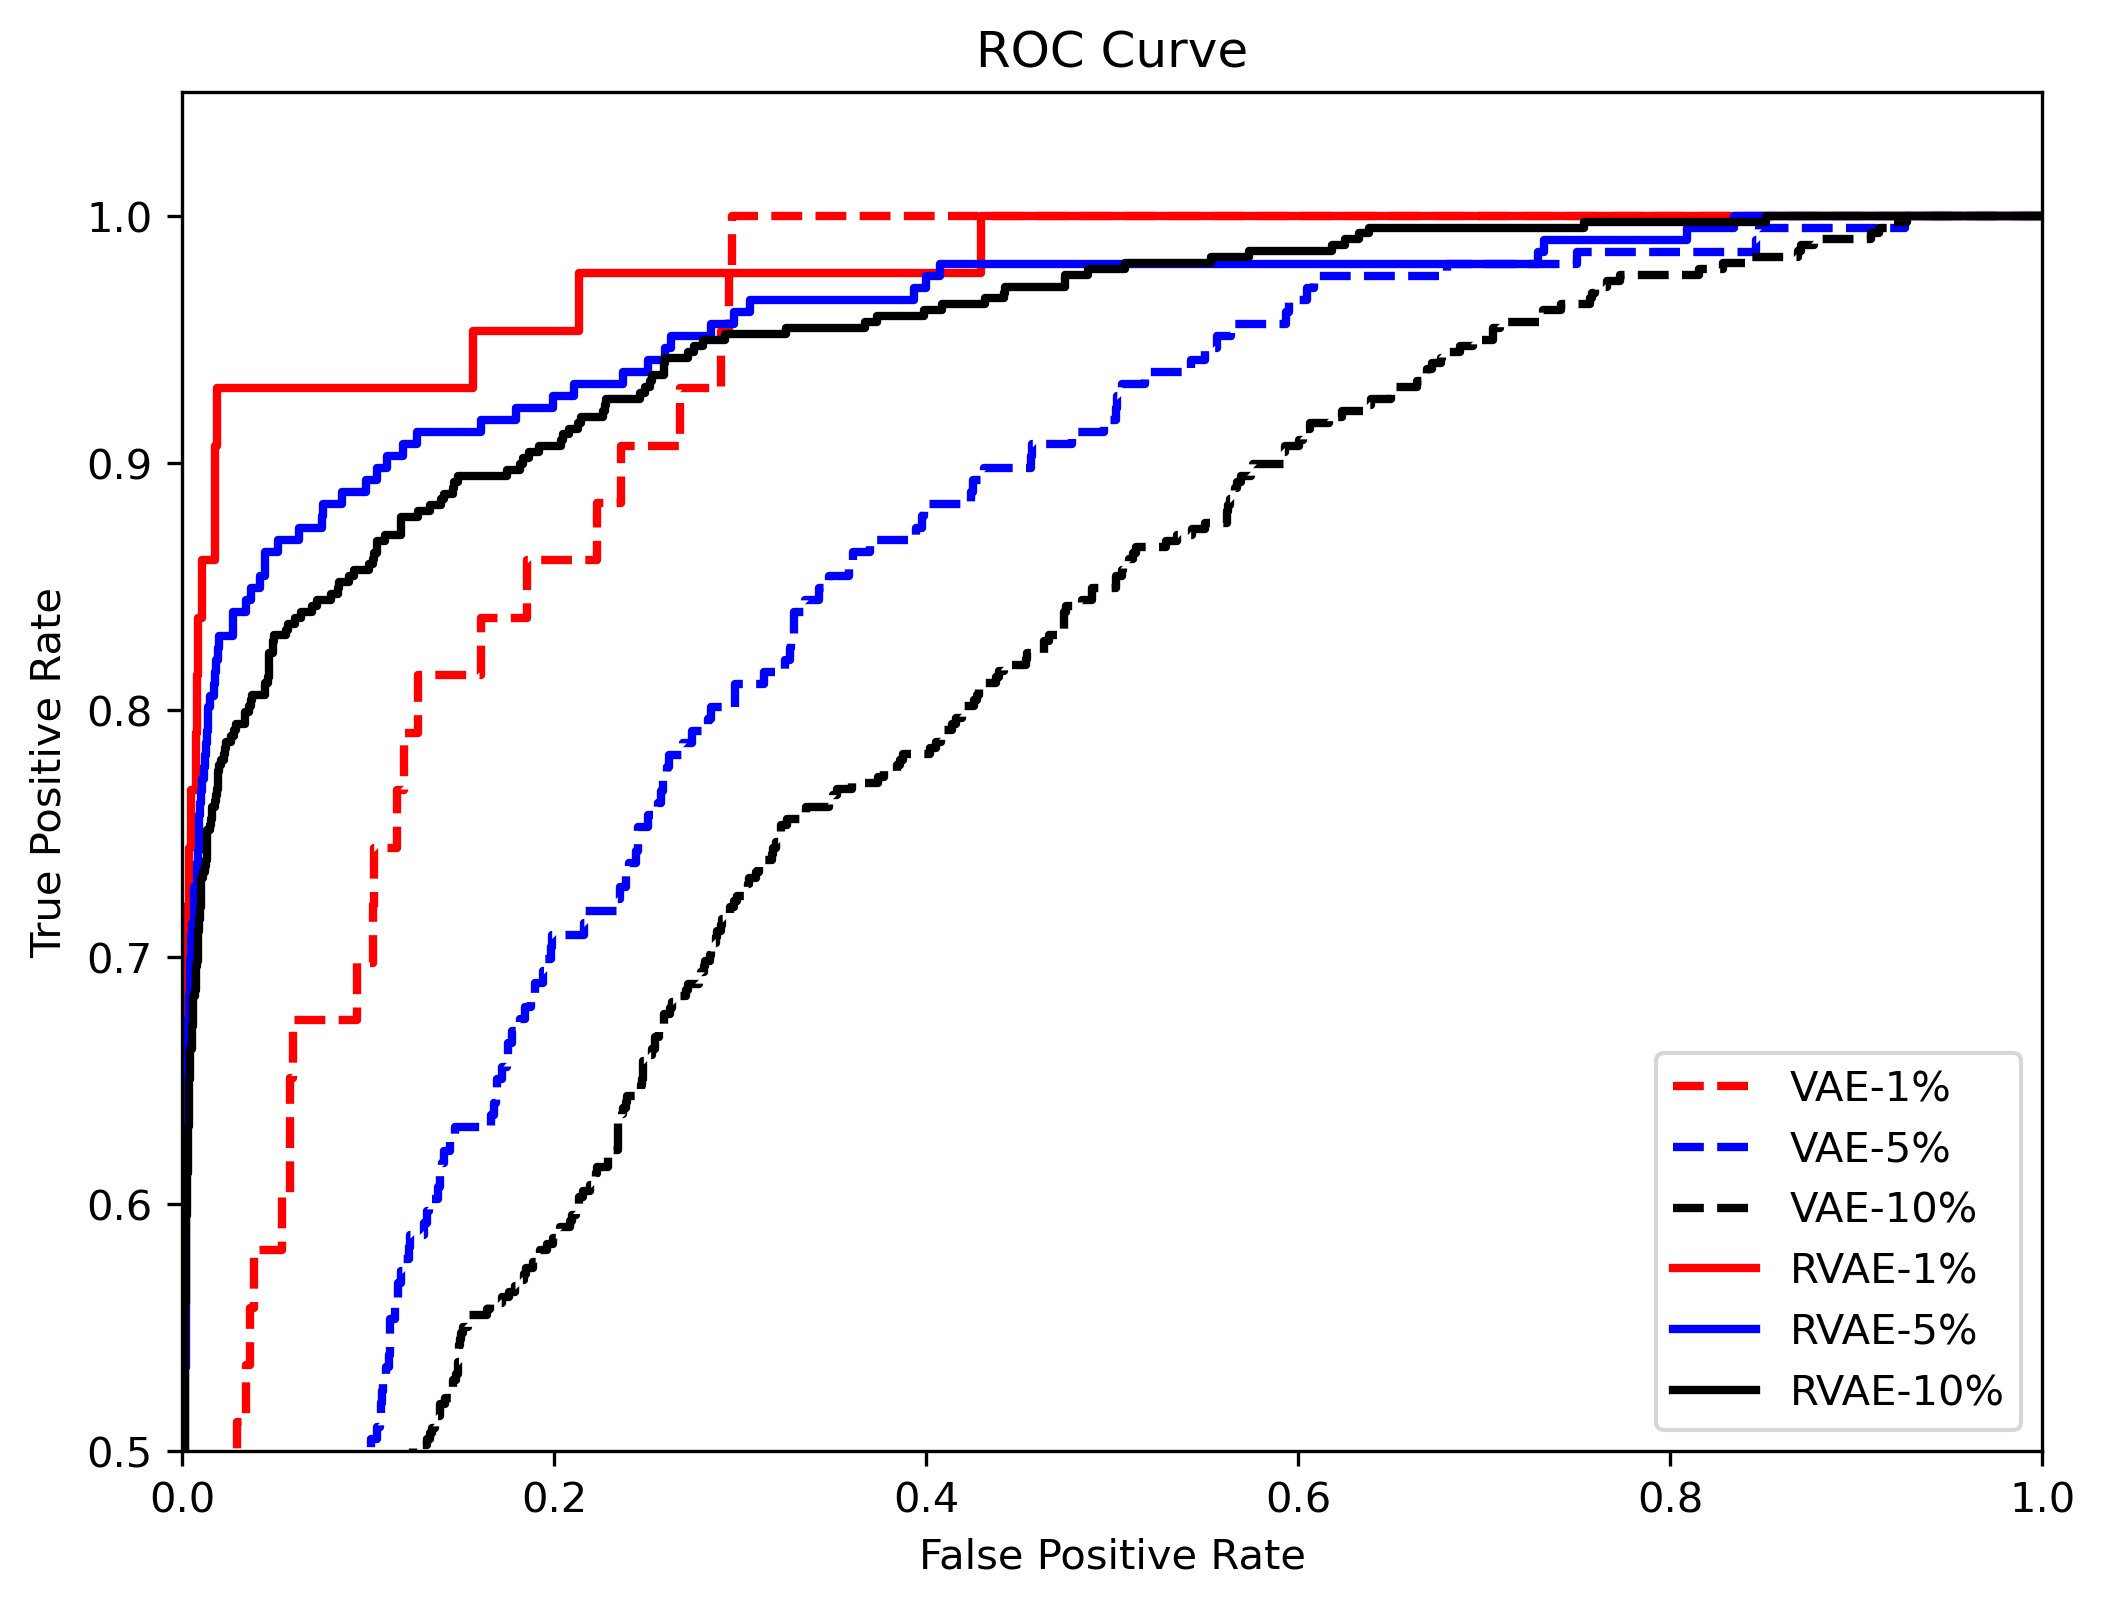

{0: 0.92639122251842, 1: 0.8354053410989443, 2: 0.7802035181377807, 3: 0.9786737595810748, 4: 0.958488292100077, 5: 0.9514830914872521}


In [49]:
lw = 2
fig = plt.figure(figsize=(8, 6), dpi=300)
for c in np.arange(0, len(FPRs)):
    fpr = FPRs[c]
    tpr = TPRs[c]

    plt.plot(fpr, tpr, lsty[c], color=colors[c], lw=lw, label=lgd[c])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')


plt.xlim([0.0, 1.0])
plt.ylim([0.5, 1.05])
plt.legend()
plt.show()

fig.savefig('results/ROCn_fashion_mnist.png')

print(AUC)